In [3]:
import numpy as np
import pandas as pd

original_path = "C:/Python_practice/DL_project/gwangjin_contest/EDA_and_Model/3.LogAndRobustScaled_UMAP_Clustering_Tuning/"

In [14]:
train_df_umap = pd.read_csv(original_path + "HDBSCAN_cluster_without_noise_manhattan.csv", index_col=0)
del train_df_umap['HDBSCAN_cluster_without_noise']
train_df_umap.head(5)

,UMAP1,UMAP2
지번주소,,
서울특별시 광진구 광장동 105,-1.653530,12.051132
서울특별시 광진구 광장동 106,-1.655412,12.049907
서울특별시 광진구 광장동 107,-1.638430,12.039934
서울특별시 광진구 광장동 108,-0.776712,12.278508
서울특별시 광진구 광장동 110,-0.791116,12.263251


## hdbscan 파라미터 튜닝

In [15]:
# 실루엣 점수 계산 함수
def silhouette(clustering_result) : 
    from sklearn.metrics import silhouette_score

    # 클러스터링 결과에서 노이즈 포인트 제외한 데이터와 클러스터 레이블 추출
    X = clustering_result.loc[clustering_result['HDBSCAN_cluster_without_noise'] != -1, ['UMAP1', 'UMAP2']]
    labels = clustering_result.loc[clustering_result['HDBSCAN_cluster_without_noise'] != -1, 'HDBSCAN_cluster_without_noise']

    # 실루엣 점수 계산
    silhouette_avg = silhouette_score(X, labels)

    return silhouette_avg

In [29]:
# 노이즈 포인트를 제외한 클러스터링 결과
def get_without_noise_hdbscan(train_df_umap) :
    from hdbscan import HDBSCAN

    min_cluster_size = range(100, 1001, 100)
    min_samples = range(3, 16, 2)
    cluster_selection_epsilon = [float(x) for x in np.around(np.arange(0.1, 1.1, 0.1), decimals=1)]
    result=[] # 결과 저장
    for a in min_cluster_size : 
        for b in min_samples : 
            for c in cluster_selection_epsilon : 
                # HDBSCAN 객체 생성 및 매개 변수 설정
                hdbscan_clustering = HDBSCAN(
                    min_cluster_size=a,  # 클러스터 최소 크기 조정 -> 이 값보다 작은 클러스터는 노이즈로 간주 (값이 작을수록 군집 수 증가)
                    min_samples=b,  # 이웃의 최소 개수 조정 
                                    # (값 늘리면 : 더 안정적인 클러스터 생성 + 노이즈 감소, but 군집 수 감소)
                                    # (값 줄이면 : 더 많은 클러스터가 생성)
                    cluster_selection_epsilon=c  # 클러스터 간의 최소 거리 조정 (값 늘리면 : 군집 수 감소 | 값 줄이면 : 군집 수 증가)
                )

                # HDBSCAN 학습
                hdbscan_clustering.fit(train_df_umap)

                # 클러스터링 결과를 train_df_umap DataFrame에 추가
                train_df_umap['HDBSCAN_cluster_without_noise'] = hdbscan_clustering.labels_
                train_df_umap = train_df_umap[train_df_umap['HDBSCAN_cluster_without_noise'] != -1]  # 노이즈 포인트 제거

                # 실루엣 점수가 0.75 초과인 것만 저장
                silhouette_avg = silhouette(train_df_umap)
                if silhouette_avg > 0.30 :
                    result.append(f"silhouette_avg: {silhouette_avg}, min_cluster_size: {a}, min_samples: {b}, cluster_selection_epsilon: {c}")

    return result

best_parms = get_without_noise_hdbscan(train_df_umap)
best_parms

C:\Users\dohee\AppData\Local\Temp\ipykernel_20456\1387983333.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_umap['HDBSCAN_cluster_without_noise'] = hdbscan_clustering.labels_


['silhouette_avg: 0.437802311331576, min_cluster_size: 100, min_samples: 3, cluster_selection_epsilon: 0.1',
 'silhouette_avg: 0.46665646760802215, min_cluster_size: 100, min_samples: 3, cluster_selection_epsilon: 0.2',
 'silhouette_avg: 0.4617777453286771, min_cluster_size: 100, min_samples: 3, cluster_selection_epsilon: 0.3',
 'silhouette_avg: 0.45820304642498005, min_cluster_size: 100, min_samples: 3, cluster_selection_epsilon: 0.4',
 'silhouette_avg: 0.47852126551960233, min_cluster_size: 100, min_samples: 3, cluster_selection_epsilon: 0.5',
 'silhouette_avg: 0.47912084021213674, min_cluster_size: 100, min_samples: 3, cluster_selection_epsilon: 0.6',
 'silhouette_avg: 0.4847376657912805, min_cluster_size: 100, min_samples: 3, cluster_selection_epsilon: 0.7',
 'silhouette_avg: 0.49634020133900736, min_cluster_size: 100, min_samples: 3, cluster_selection_epsilon: 0.8',
 'silhouette_avg: 0.483901718092862, min_cluster_size: 100, min_samples: 3, cluster_selection_epsilon: 0.9',
 'silho

In [30]:
best_param = max(best_parms, key=lambda x: x.split(",")[0].split(":")[1])
print("Best params: " + best_param)

Best params: silhouette_avg: 0.725000146959276, min_cluster_size: 700, min_samples: 3, cluster_selection_epsilon: 0.2


In [31]:
# best_param 데이터프레임으로 변환
df = pd.DataFrame({'params': best_parms})

df[['silhouette_avg', 'min_cluster_size', 'min_samples', 'cluster_selection_epsilon']] = df['params'].str.extract(r'silhouette_avg: ([\d\.]+), min_cluster_size: (\d+), min_samples: (\d+), cluster_selection_epsilon: ([\d\.]+)')
df.drop('params', axis=1, inplace=True)
df = df.astype({'silhouette_avg': 'float64', 'min_cluster_size': 'int64', 'min_samples': 'int64', 'cluster_selection_epsilon': 'float64'})
df

,silhouette_avg,min_cluster_size,min_samples,cluster_selection_epsilon
0,0.437802,100,3,0.1
1,0.466656,100,3,0.2
2,0.461778,100,3,0.3
3,0.458203,100,3,0.4
4,0.478521,100,3,0.5
...,...,...,...,...
695,0.588253,1000,15,0.6
696,0.588253,1000,15,0.7
697,0.588253,1000,15,0.8
698,0.588253,1000,15,0.9


In [32]:
df.to_excel('C:/Python_practice/DL_project/gwangjin_contest/EDA_and_Model/4.Clustering_Tuning/HDBSCAN_best_params.xlsx', index=False)

## best 파라미터로 클러스터링 결과 확인

In [37]:
train_df_umap = pd.read_csv(original_path + "HDBSCAN_cluster_without_noise_manhattan.csv", index_col=0)
del train_df_umap['HDBSCAN_cluster_without_noise']

In [38]:
# 노이즈 포인트를 제외한 클러스터링 결과
def get_without_noise_hdbscan(train_df_umap) :
    from hdbscan import HDBSCAN

    # HDBSCAN 객체 생성 및 매개 변수 설정 (min_cluster_size 등)
    hdbscan_clustering = HDBSCAN(
        min_cluster_size=700,
        min_samples=15,
        cluster_selection_epsilon=1
    )

    # UMAP으로 축소된 데이터(train_df_umap)에 HDBSCAN 적용
    hdbscan_clustering.fit(train_df_umap)

    # 모델 저장
    import pickle

    with open("C:/Python_practice/DL_project/gwangjin_contest/EDA_and_Model/4.Clustering_Tuning/second_priority/LogAndRobustScaled_UMAP_HDBSCAN_manhattan_v2.pkl", "wb") as file:
        pickle.dump(hdbscan_clustering, file)


    # 클러스터링 결과를 train_df_umap DataFrame에 추가
    train_df_umap['HDBSCAN_cluster_without_noise'] = hdbscan_clustering.labels_
    train_df_umap = train_df_umap[train_df_umap['HDBSCAN_cluster_without_noise'] != -1]  # 노이즈 포인트 제거
    
    return train_df_umap

get_without_noise_hdbscan = get_without_noise_hdbscan(train_df_umap)
get_without_noise_hdbscan

,UMAP1,UMAP2,HDBSCAN_cluster_without_noise
지번주소,,,
서울특별시 광진구 광장동 108,-0.776712,12.278508,0
서울특별시 광진구 광장동 110,-0.791116,12.263251,0
서울특별시 광진구 광장동 112,-0.823864,12.235266,0
서울특별시 광진구 광장동 114,-0.779042,12.280546,0
서울특별시 광진구 광장동 124,-0.745868,12.293220,0
...,...,...,...
서울특별시 광진구 화양동 94-82,-1.390074,4.648668,3
서울특별시 광진구 화양동 94-9,-1.382601,4.650796,3
서울특별시 광진구 화양동 95-3,2.870096,-0.098210,3


In [39]:
# 실루엣 점수 계산 함수
def silhouette(clustering_result) : 
    from sklearn.metrics import silhouette_score

    # 클러스터링 결과에서 노이즈 포인트 제외한 데이터와 클러스터 레이블 추출
    X = clustering_result.loc[clustering_result['HDBSCAN_cluster_without_noise'] != -1, ['UMAP1', 'UMAP2']]
    labels = clustering_result.loc[clustering_result['HDBSCAN_cluster_without_noise'] != -1, 'HDBSCAN_cluster_without_noise']

    # 실루엣 점수 계산
    silhouette_avg = silhouette_score(X, labels)

    return silhouette_avg

from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import DistanceMetric

# Dunn 지수 계산 함수
def dunn(clustering_result):
    dist = DistanceMetric.get_metric('euclidean')
    labels = clustering_result['HDBSCAN_cluster_without_noise']
    clusters = np.unique(labels)
    centroids = [np.mean(clustering_result.loc[labels==i, ['UMAP1', 'UMAP2']], axis=0) for i in clusters]
    max_intracluster_distances = [np.max(dist.pairwise(clustering_result.loc[labels==i, ['UMAP1', 'UMAP2']])) for i in clusters]
    min_intercluster_distances = []
    for i, c1 in enumerate(centroids):
        for j, c2 in enumerate(centroids):
            if i < j:
                dist_ij = dist.pairwise([c1, c2])[0][1]
                min_intercluster_distances.append(dist_ij)
    return np.min(min_intercluster_distances) / np.max(max_intracluster_distances)

# Calinski-Harabasz 지수 계산 함수
def calinski_harabasz(clustering_result):
    labels = clustering_result['HDBSCAN_cluster_without_noise']
    return calinski_harabasz_score(clustering_result[['UMAP1', 'UMAP2']], labels)

# Dunn 지수와 Calinski-Harabasz 지수 계산
sil_score = silhouette(get_without_noise_hdbscan)
dunn_score = dunn(get_without_noise_hdbscan)
ch_score = calinski_harabasz(get_without_noise_hdbscan)

# 출력
print(f"실루엣 score: {sil_score}")
print(f"Dunn score: {dunn_score:.4f}")
print(f"Calinski-Harabasz score: {ch_score:.4f}")

C:\Users\dohee\AppData\Roaming\Python\Python39\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


실루엣 score: 0.2394397918957732
Dunn score: 0.4509
Calinski-Harabasz score: 5373.0462


In [42]:
get_without_noise_hdbscan.to_csv('C:/Python_practice/DL_project/gwangjin_contest/EDA_and_Model/4.Clustering_Tuning/LogAndRobustScaled_UMAP_HDBSCAN_v2.csv')

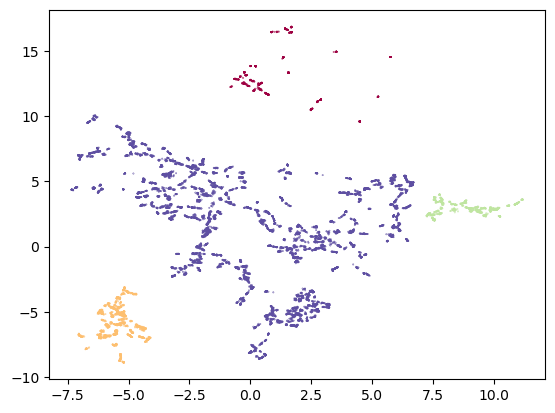

In [40]:
# 군집화 결과 시각화
def visualization_data(clustering_result):
    import matplotlib.pyplot as plt
    # 노이즈 포인트 제외
    clustered = (clustering_result['HDBSCAN_cluster_without_noise'] >= 0)
    
    plt.scatter(clustering_result[clustered]['UMAP1'],
                clustering_result[clustered]['UMAP2'],
                c=clustering_result[clustered]['HDBSCAN_cluster_without_noise'],
                s=0.1,
                cmap='Spectral')
    plt.show()
    
get_without_noise_hdbscan_v = visualization_data(get_without_noise_hdbscan)
get_without_noise_hdbscan_v

<hr>

## 재시도

In [56]:
train_df_umap = pd.read_csv(original_path + "HDBSCAN_cluster_without_noise_manhattan.csv", index_col=0)
del train_df_umap['HDBSCAN_cluster_without_noise']

In [66]:
# 노이즈 포인트를 제외한 클러스터링 결과
def get_without_noise_hdbscan(train_df_umap) :
    from hdbscan import HDBSCAN

    # HDBSCAN 객체 생성 및 매개 변수 설정 (min_cluster_size 등)
    hdbscan_clustering = HDBSCAN(
        min_cluster_size=700,
        min_samples=15,
        cluster_selection_epsilon=0.4
    )

    # UMAP으로 축소된 데이터(train_df_umap)에 HDBSCAN 적용
    hdbscan_clustering.fit(train_df_umap)

    # 모델 저장
    import pickle

    with open("C:/Python_practice/DL_project/gwangjin_contest/EDA_and_Model/4.Clustering_Tuning/second_priority/LogAndRobustScaled_UMAP_HDBSCAN_manhattan_v4.pkl", "wb") as file:
        pickle.dump(hdbscan_clustering, file)


    # 클러스터링 결과를 train_df_umap DataFrame에 추가
    train_df_umap['HDBSCAN_cluster_without_noise'] = hdbscan_clustering.labels_
    train_df_umap = train_df_umap[train_df_umap['HDBSCAN_cluster_without_noise'] != -1]  # 노이즈 포인트 제거
    
    return train_df_umap

get_without_noise_hdbscan = get_without_noise_hdbscan(train_df_umap)
get_without_noise_hdbscan

,UMAP1,UMAP2,HDBSCAN_cluster_without_noise
지번주소,,,
서울특별시 광진구 광장동 105,-1.653530,12.051132,0
서울특별시 광진구 광장동 106,-1.655412,12.049907,0
서울특별시 광진구 광장동 107,-1.638430,12.039934,0
서울특별시 광진구 광장동 108,-0.776712,12.278508,0
서울특별시 광진구 광장동 110,-0.791116,12.263251,0
...,...,...,...
서울특별시 광진구 화양동 94-82,-1.390074,4.648668,6
서울특별시 광진구 화양동 94-9,-1.382601,4.650796,6
서울특별시 광진구 화양동 95-3,2.870096,-0.098210,5


In [67]:
# Dunn 지수와 Calinski-Harabasz 지수 계산
sil_score = silhouette(get_without_noise_hdbscan)
dunn_score = dunn(get_without_noise_hdbscan)
ch_score = calinski_harabasz(get_without_noise_hdbscan)

# 출력
print(f"실루엣 score: {sil_score}")
print(f"Dunn score: {dunn_score:.4f}")
print(f"Calinski-Harabasz score: {ch_score:.4f}")

C:\Users\dohee\AppData\Roaming\Python\Python39\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


실루엣 score: 0.4206485082697617
Dunn score: 0.2219
Calinski-Harabasz score: 13887.0877


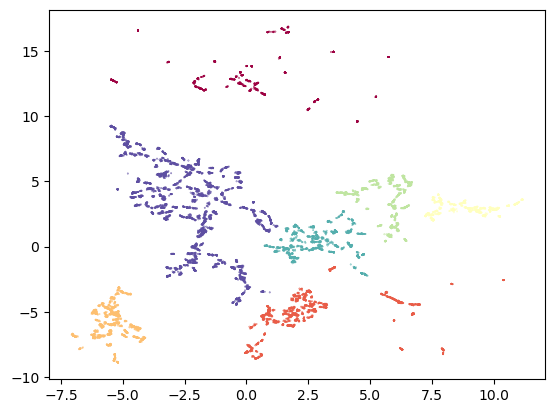

In [68]:
get_without_noise_hdbscan_v = visualization_data(get_without_noise_hdbscan)
get_without_noise_hdbscan_v

In [69]:
get_without_noise_hdbscan.to_csv('C:/Python_practice/DL_project/gwangjin_contest/EDA_and_Model/4.Clustering_Tuning/LogAndRobustScaled_UMAP_HDBSCAN_v4.csv')